In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
class DNN(torch.nn.Module):
    def __init__(self, d, m, nTh, nex):
        
        super().__init__()

        if nTh < 2:
            print("nTh must be an integer >= 2")
            exit(1)

        self.d = d
        self.m = m
        self.nTh = nTh
        self.nex = nex

        self.layers = torch.nn.ModuleList([])
        self.layers.append(torch.nn.Linear(d, m, bias=True))
        for i in range(nTh-2):
            self.layers.append(torch.nn.Linear(m, m, bias=True))
        self.layers.append(torch.nn.Linear(m, d, bias=False))
        

    def forward(self, x):
        x = torch.relu(self.layers[0].forward(x))
        for i in range(1, self.nTh-1):
            x = torch.relu(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [3]:
class Score_Matching():
    def __init__(self, v):
        self.v = v.to(device) # velocity
        self.nex = v.shape[0] # number of particles
        self.d = v.shape[1] # dimension

        # neural network
        self.net = DNN(nTh=4, m=100, d=self.d, nex=self.nex).to(device)

        # optimizer Adam
        self.optimizer = torch.optim.ASGD(self.net.parameters(), lr=1e-2)

        # self.optimizer2 = torch.optim.LBFGS(
        #     self.net.parameters(), 
        #     lr=1.0, 
        #     max_iter=10000, 
        #     max_eval=50000, 
        #     history_size=100,
        #     tolerance_grad=1e-16, 
        #     tolerance_change=1.0 * np.finfo(float).eps,
        #     line_search_fn="strong_wolfe")
        self.iter = 0


    def loss(self):
        v = self.v

        div_u = 0
        u = self.net(v)
        for i in range(self.nex):
            u_v = torch.autograd.functional.jacobian(self.net, v[i,:], create_graph=True)
            div_u = div_u + u_v.trace()

        loss = (torch.norm(u)**2 + 2*div_u ) / self.nex

        self.optimizer.zero_grad()
        loss.backward()

        print('Iter %d, Loss: %.5e' % (self.iter, loss.item()))

        self.iter += 1
        return loss


    # def loss(self):
    #     v=self.v
    #     loss = torch.sum( torch.pow(self.net(v) + v, 2) * torch.exp(-1* v**2 / 2) ) / self.nex

    #     self.optimizer.zero_grad()
    #     loss.backward()

    #     print('Iter %d, Loss: %.5e' % (self.iter, loss.item()))

    #     self.iter += 1
    #     return loss


    def train(self):
        while self.iter <= 2000:
            self.optimizer.step(self.loss)

    def predict(self):
        u = self.net(self.v)
        return u

In [4]:
nex = 500
d = 1
v = torch.randn(nex, d, requires_grad=True)

model = Score_Matching(v)

In [7]:
model.train()

Iter 9, Loss: -2.37968e-01
Iter 10, Loss: -2.60621e-01
Iter 11, Loss: -2.83367e-01
Iter 12, Loss: -3.06170e-01
Iter 13, Loss: -3.28603e-01
Iter 14, Loss: -3.51560e-01
Iter 15, Loss: -3.74878e-01
Iter 16, Loss: -3.97809e-01
Iter 17, Loss: -4.21678e-01
Iter 18, Loss: -4.44537e-01
Iter 19, Loss: -4.68233e-01
Iter 20, Loss: -4.91919e-01
Iter 21, Loss: -5.14178e-01
Iter 22, Loss: -5.35519e-01
Iter 23, Loss: -5.57774e-01
Iter 24, Loss: -5.77073e-01
Iter 25, Loss: -5.97901e-01
Iter 26, Loss: -6.19350e-01
Iter 27, Loss: -6.37530e-01
Iter 28, Loss: -6.57574e-01
Iter 29, Loss: -6.76293e-01
Iter 30, Loss: -6.93233e-01
Iter 31, Loss: -7.09717e-01
Iter 32, Loss: -7.24693e-01
Iter 33, Loss: -7.38048e-01
Iter 34, Loss: -7.53416e-01
Iter 35, Loss: -7.67985e-01
Iter 36, Loss: -7.77464e-01
Iter 37, Loss: -7.87927e-01
Iter 38, Loss: -7.98609e-01
Iter 39, Loss: -8.11597e-01
Iter 40, Loss: -8.19885e-01
Iter 41, Loss: -8.29027e-01
Iter 42, Loss: -8.34505e-01
Iter 43, Loss: -8.40703e-01
Iter 44, Loss: -8.490

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

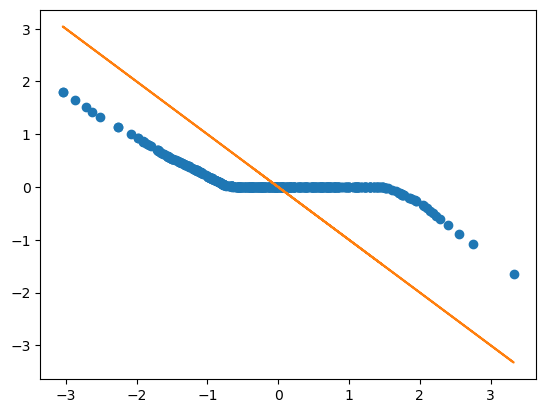

In [8]:
u = model.predict().cpu().detach().numpy()
v1 = v.cpu().detach().numpy()
plt.plot(v1, u, 'o')
plt.plot(v1,-1*v1,'-')
plt.show

In [ ]:
def func(v):
    x=v**2 + 3*v[0] + v[1]
    return x
nex = 3
d = 2
v = torch.ones(nex, d, requires_grad=True)
for i in range(nex):
    a = torch.autograd.functional.jacobian(func, v[i,:], create_graph=True)